In [1]:
# import torch
import numpy as np
import os

In [7]:
import os

def print_tree(root_dir, indent=""):
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        print(indent + "|-- " + item)
        if os.path.isdir(item_path):
            print_tree(item_path, indent + "    ")

root_dir = '/home/jovyan/fokin/modded-nanogpt/runs'
print_tree(root_dir)


|-- 11.01_30765_hyp_30.0_1
    |-- tensorboard_logs
        |-- events.out.tfevents.1736573565.hopper-h100-0.409366.0
    |-- config.json
    |-- log.txt
|-- 11.01_38768_hyp_learn_30.0_1
    |-- tensorboard_logs
        |-- events.out.tfevents.1736581568.hopper-h100-0.410731.0
    |-- config.json
    |-- log.txt
|-- 11.01_49656_hyp_300.0_lr_1e+00_1
    |-- tensorboard_logs
        |-- events.out.tfevents.1736592456.hopper-h100-0.460194.0
    |-- config.json
    |-- log.txt
|-- 11.01_51041_euc_1
    |-- tensorboard_logs
        |-- events.out.tfevents.1736593841.hopper-h100-0.471607.0
    |-- config.json
    |-- log.txt
|-- 11.01_22558_hyp_learn_10.0_1
    |-- tensorboard_logs
        |-- events.out.tfevents.1736565358.hopper-h100-0.407530.0
    |-- config.json
    |-- log.txt
|-- 11.01_46920_hyp_300.0_lr_1e-01_1
    |-- tensorboard_logs
        |-- events.out.tfevents.1736589720.hopper-h100-0.435214.0
    |-- config.json
    |-- log.txt
|-- 11.01_55064_hyp_1000.0_lr_1e-01_1
    |-- ten

In [8]:
root_dir = '/home/jovyan/fokin/modded-nanogpt/runs'

# Get a list of all experiment folders
logdirs = [os.path.join(root_dir, d, 'tensorboard_logs') for d in os.listdir(root_dir) \
           if (('26.01' in d) or ('27.01' in d) or ('26.12' in d) or ('27.12' in d))]
logdirs

['/home/jovyan/fokin/modded-nanogpt/runs/27.01_3409_euc_head_3/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/27.01_8362_euc_head_4/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.01_82055_euc_head_1/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.01_84876_euc_head_2/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.01_84812_k_1.0_lr_10.0_1/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.12_42750_hyp_90.0/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.12_44765_hyp_90.0/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.12_46725_hyp_90.0/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.12_48688_hyp_90.0/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.12_50642_hyp_120.0/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.12_52614_hyp_120.0/tensorboard_logs',
 '/home/jovyan/fokin/modded-nanogpt/runs/26.12_54584_hyp_120.0/tensorboard_logs',
 '/home/jovy

In [3]:
def get_exp_name(log_dir):
    suffix = log_dir.split(os.sep)[-2].split('_')[-1]
    if suffix == 'euc':
        return suffix
    else:
        return "_".join(log_dir.split(os.sep)[-2].split('_')[-2:])

In [4]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

logs_to_show=logdirs
# exp_names = [n[23:36] for n in logs_to_show]
exp_names = {}

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    exp_name = get_exp_name(log_dir)
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get available scalar tags (train/loss, val/loss, learning_rate, Gradient Norm)
    tags = ['Loss/Train', 'Loss/Validation'] 
    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}
            run_len = len(steps)
    # Store the extracted data for this experiment folder
    if run_len > 1:
        if exp_name in experiment_data.keys():
            experiment_data[exp_name].append(data)
        else:
            experiment_data[exp_name] = [data]

In [5]:
from pprint import pprint

def get_dict_shape(d, level=0):
    if isinstance(d, dict):
        shape = {k: get_dict_shape(v, level+1) for k, v in d.items()}
    elif isinstance(d, list):
        shape = (len(d), [get_dict_shape(v, level+1) for v in d[:1]][0])  # Only examine the first element
    else:
        shape = type(d).__name__
    return shape


def average_dict(d):
    av_train = {}
    av_val = {}
    for k, v in d.items():
        train, val = [], []
        for s in v:
            tv = s['Loss/Train']['values']
            vv = s['Loss/Validation']['values']
            # if len(tv) < 61:
            #     tv.append(np.nan)
            # if len(vv) < 27:
            #     vv.append(np.nan)
            # if len(tv) >= 60:
            #     train.append(tv)
            #     val.append(vv)
            print(len(tv), len(vv))
        av_train[k] = {'mean' : np.array(train).mean(axis=0),
                       'std' : np.array(train).std(axis=0)}
        av_val[k] = {'mean' : np.array(val).mean(axis=0),
                       'std' : np.array(val).std(axis=0)}
    return av_train, av_val

av_train, av_val = average_dict(experiment_data)
shape = get_dict_shape(experiment_data)
pprint(shape)

100 101
6 6
100 101
100 101
100 101
6 6
10 11


/tmp/ipykernel_806651/2875615763.py:29: RuntimeWarning: Mean of empty slice.
  av_train[k] = {'mean' : np.array(train).mean(axis=0),
/home/jovyan/miniconda3/envs/fokin_HCNN/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jovyan/miniconda3/envs/fokin_HCNN/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/miniconda3/envs/fokin_HCNN/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jovyan/miniconda3/envs/fokin_HCNN/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_806651/2875615763.py:31: RuntimeWarning: Mean of empty slice

KeyError: 'Loss/Train'

In [14]:
len(av_val.items())

6

/tmp/ipykernel_308874/2782059441.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')  # Use a colormap with distinct colors


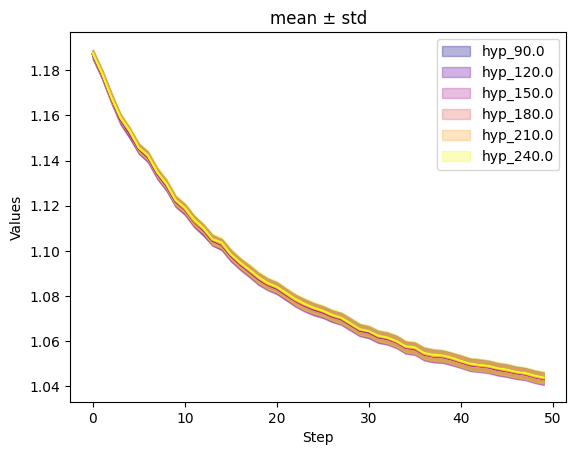

In [21]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_av(av, start=0, end=-1):

    cmap = cm.get_cmap('plasma')  # Use a colormap with distinct colors
    colors = [cmap(i) for i in np.linspace(0, 1, len(av.items()))]

    for i, (k, v) in enumerate(av.items()):
        mean = v['mean'][start:end]
        std = v['std'][start:end]
        upper_bound = mean + std
        lower_bound = mean - std

        # Plot the bounds
        # plt.plot(upper_bound, color=colors[i])
        plt.plot(mean, color=colors[i])

        # Fill in-between
        plt.fill_between(range(len(mean)), lower_bound, upper_bound, color=colors[i], alpha=0.3, label=f'{k}')

    plt.xlabel("Step")
    plt.ylabel("Values")
    plt.legend()
    plt.title("mean ± std")
    plt.show()

plot_av(av_val, start=10)

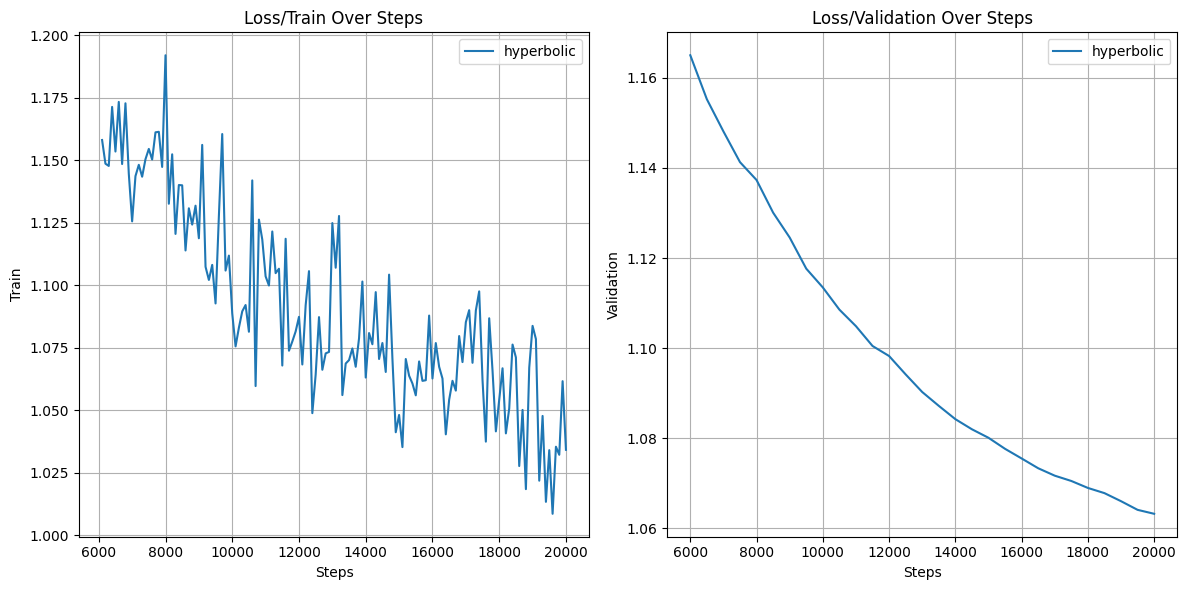

In [13]:
metrics = ['Loss/Train', 'Loss/Validation'] #['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']

# exp_names = ['hyperbolic c=1e-5', 'original']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 2x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    boo = True
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            if boo:
                length = len(data[metric]['steps'])
                boo = False
            from_, to_ = int(0.1*length), int(1*length)
            steps = data[metric]['steps'][from_:to_]
            values = data[metric]['values'][from_:to_]
            ax.plot(steps, values, label=e)
    
    if 'learning' in metric:
        ax.set_yscale('log')  
    ax.set_xlabel('Steps')
    # ax.set_xlim([0, 1.1*max(steps)])
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
# plt.savefig('runs_head.jpg')
plt.show()

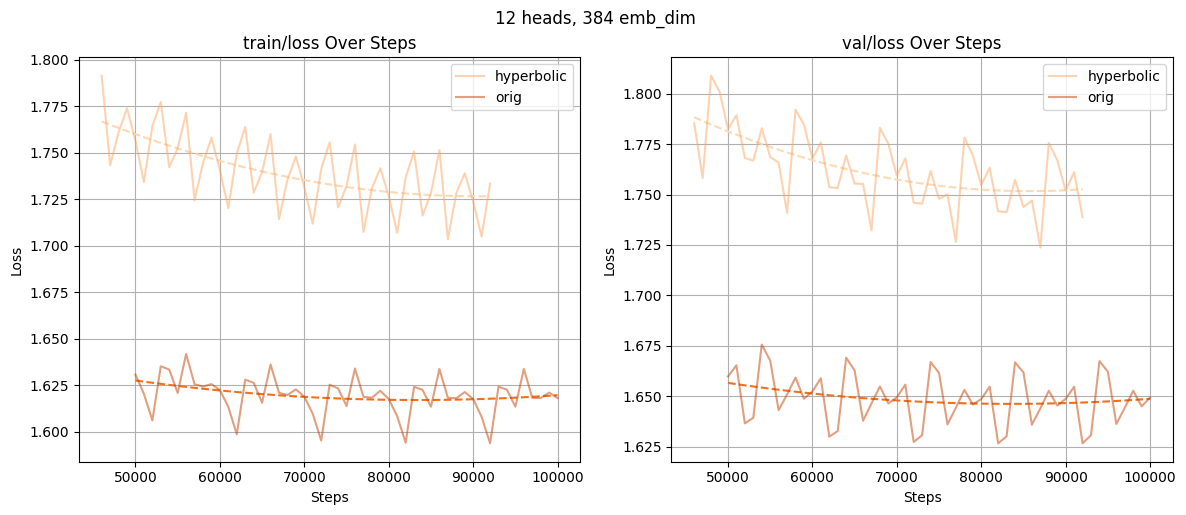

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os
import seaborn as sns

# Set the Seaborn color palette
palette = sns.color_palette("Oranges", n_colors=4)  # husl, deep, bright, etc.
plt.rc('axes', prop_cycle=plt.cycler('color', palette))

# Function to fit a parabola and plot
def fit_and_plot_parabola(ax, steps, values, label):
    # Fit a quadratic function (parabola)
    coefs = np.polyfit(steps, values, 2)  # 2 for quadratic fit
    poly = np.poly1d(coefs)
    
    # Generate points for plotting the parabola
    fitted_values = poly(steps)
    
    # Plot the fitted parabola
    ax.plot(steps, fitted_values, linestyle='--') #label=f'{label} quadratic fit'
    
    # Find the minimum of the parabola
    min_step = -coefs[1] / (2 * coefs[0])
    min_value = poly(min_step)
    
    # Highlight the minimum point
    ax.scatter(min_step, min_value, color='red', zorder=5)
    
    return min_step, min_value

# Filter logs to only show train/loss and val/loss
logs_to_show = log_dirs
# exp_names = [n[23:36] for n in logs_to_show]
exp_names = ['hyperbolic', 'orig']

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    # Get available scalar tags (train/loss, val/loss)
    tags = ['train/loss', 'val/loss']

    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  # Check if tag is available
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}

    # Store the extracted data for this experiment folder
    experiment_data[os.path.basename(log_dir)] = data

metrics = ['train/loss', 'val/loss']  # Only include loss metrics

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            length = len(data[metric]['steps'])
            from_, to_ = int(0.5*length), int(length)
            steps = data[metric]['steps'][from_:to_]
            values = data[metric]['values'][from_:to_]
            ax.plot(steps, values, label=e, alpha=0.5)
            
            # Fit the loss with a parabola and highlight the minimum point
            fit_and_plot_parabola(ax, steps, values, e)
    
    ax.set_xlabel('Steps')
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
plt.suptitle('12 heads, 384 emb_dim', y=1.02)
plt.show()